# Titanic: Who Will Survive?

This notebook is for the famous **Titanic** competition. It's based on Daniel Bourke's notebook with enhancements.

<p align = "center">
    <img src = "https://kerrycoaches.com/wp-content/uploads/2017/02/Titanic-1.jpg" >
</p>
<p style="text-align:center">
    Image via <a href="https://kerrycoaches.com/2017/03/12/12-surprising-facts-ireland/titanic-2/" target="_blank">kerrycoaches.com</a>
</p>


## 1. Introduction

In [1231]:
# --- Import libraries and dependencies ---

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
import math, time, random, datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [796]:
# --- Import train & test Datasets ---

train_url ='https://raw.githubusercontent.com/ufukeskici/datasets/main/titanic/train.csv'
test_url ='https://raw.githubusercontent.com/ufukeskici/datasets/main/titanic/test.csv'
gender_submission_url ='https://raw.githubusercontent.com/ufukeskici/datasets/main/titanic/gender_submission.csv'

train = pd.read_csv(train_url, sep=',')
test = pd.read_csv(test_url, sep=',')
gender_submission = pd.read_csv(gender_submission_url, sep=',')

In [5]:
# --- Check the imported train file ---

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# --- Check the imported test file ---

test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Data Dictionary

| Variable  | Definition                                 | Key                                             |
| :-------- | :------------------------------------------| :-----------------------------------------------|
| Survived  | Survival                                   | 0 = No, 1 = Yes                                 |
| Pclass    | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                       |
| Name      | Name of the passenger                      |                                                 |
| Sex       | Sex                                        |	                                               |
| Age	    | Age in years                               |                                                 |
| SibSp     | # of siblings / spouses aboard the Titanic | 	                                               |
| Parch	    | # of parents / children aboard the Titanic |                                                 |
| Ticket	| Ticket number                              |                                                 |
| Fare	    | Passenger fare                             |                                                 |
| Embarked	| Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton  |
| Cabin	    | Cabin number	                             |                                                 |

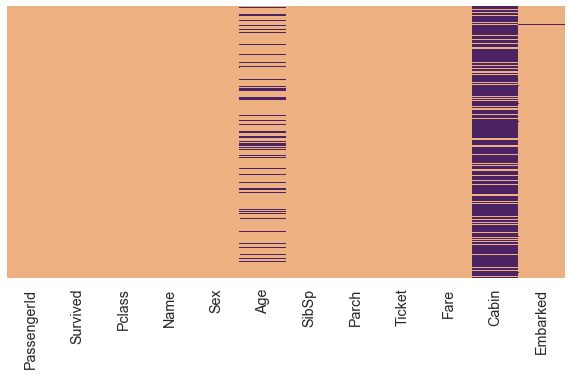

In [782]:
# --- Visualize the missing values in the training dataset ---

plt.figure(figsize=(10,5))
sns.set(font_scale=1.3)
sns.heatmap(train.isnull(), yticklabels=False, cmap="flare", cbar=False);

There are missing values in `Embarked`, `Age` and `Cabin` columns. We need to look into these features later.

In [465]:
# --- Calculate the number of missing values of each feature ---

train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# --- Check the data types ---

train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
# --- Describe the numerical features ---

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# --- Describe the categorical features ---

train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Rugg, Miss. Emily",male,347082,G6,S
freq,1,577,7,4,644


In [12]:
# --- Create new dataframes ---

df_bin = pd.DataFrame() # for discretised continous variable
df_con = pd.DataFrame() # for continous variables

We need to analyze each feature and then we will use them for our model accordingly.

## 2.  Preprocessing

### 2.1. Feature: Survived

In [607]:
# --- How many people survived? ---

train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

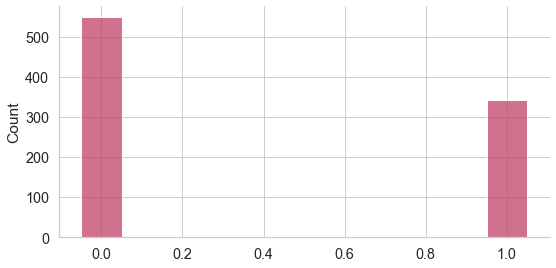

In [575]:
# --- Plot Survived Feature ---

df_temp = pd.DataFrame()
df_temp['Survived'] = train['Survived']

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=df_temp, kind="hist", palette="flare", legend=False,
           height=4.0, aspect=2.0, discrete=True, shrink=.1);

In [15]:
# --- Add Survived feature to our dataframes ---

df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

### 2.2. Feature: Pclass

In [16]:
# --- Check the distribution of Pclass ---

train['Pclass'].value_counts().sort_index(ascending=True)

1    216
2    184
3    491
Name: Pclass, dtype: int64

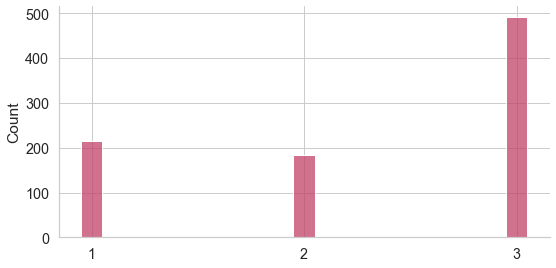

In [664]:
# --- Plot the distribution of Pclass ---

df_temp = pd.DataFrame()
df_temp['Pclass'] = train['Pclass']

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=df_temp, kind="hist", palette="flare", legend=False,
           height=4.0, aspect=2.0, discrete=True, shrink=.1);
plt.xticks([1,2,3],['1','2','3']);

Since `Pclass` is a categorical feature, we need to encode it later. Let's add it to our dataframes for now.

In [19]:
# --- Add Pclass feature to our dataframes ---

df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### 2.3. Feature: Name

In [20]:
# --- How many different names do we have? ---

train['Name'].value_counts()

Rugg, Miss. Emily                   1
Sivola, Mr. Antti Wilhelm           1
Homer, Mr. Harry ("Mr E Haven")     1
Silverthorne, Mr. Spencer Victor    1
Widener, Mr. Harry Elkins           1
                                   ..
Graham, Mr. George Edward           1
Ali, Mr. Ahmed                      1
Abbing, Mr. Anthony                 1
Wheadon, Mr. Edward H               1
Toomey, Miss. Ellen                 1
Name: Name, Length: 891, dtype: int64

There are **891** unique values in `Name` column. As we can see, passenger names include "Mr.", "Mrs.", "Miss", etc. We can use these abbreviations to create new features. But first, let's make sure if we have only 3 abbreviations or not.

In [1153]:
# --- Calculate the number of rows for each abbreviation ---

no_mr = train['Name'].str.contains(' Mr. ', case=False).sum()
no_mrs = train['Name'].str.contains(' Mrs.', case=False).sum()
no_miss = train['Name'].str.contains(' Miss.', case=False).sum()
no_other = train.shape[0] - no_mr - no_mrs - no_miss

print(f"{'Number of passengers with Mr:':<35} {no_mr}")
print(f"{'Number of passengers with Mrs:':<35} {no_mrs}")
print(f"{'Number of passengers with Miss:':<35} {no_miss}")
print(f"{'-' * 40}")
print(f"{'Number of remaining passengers:':<35} {no_other}")

Number of passengers with Mr:       517
Number of passengers with Mrs:      125
Number of passengers with Miss:     182
----------------------------------------
Number of remaining passengers:     67


In [1156]:
# --- List the remaining 67 passengers ---

df = train.loc[(train['Name'].str.contains(' Mr. ', case=False) == False) & 
               (train['Name'].str.contains(' Mrs. ', case=False) == False) & 
               (train['Name'].str.contains(' Miss. ', case=False) == False)]

df[['PassengerId', 'Name']]

,PassengerId,Name
7,8,"Palsson, Master. Gosta Leonard"
16,17,"Rice, Master. Eugene"
30,31,"Uruchurtu, Don. Manuel E"
50,51,"Panula, Master. Juha Niilo"
59,60,"Goodwin, Master. William Frederick"
...,...,...
831,832,"Richards, Master. George Sibley"
848,849,"Harper, Rev. John"
850,851,"Andersson, Master. Sigvard Harald Elias"
869,870,"Johnson, Master. Harold Theodor"


In [1157]:
# --- Increase the max_rows and max_colwitdh values to be able to see all rows and columns properly ---

pd.set_option("max_rows", None)
pd.set_option("max_colwidth", None)

In [1158]:
df[['PassengerId', 'Survived', 'Name', 'Sex']].sort_values('Sex')

,PassengerId,Survived,Name,Sex
710,711,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female
443,444,1,"Reynaldo, Ms. Encarnacion",female
759,760,1,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",female
556,557,1,"Duff Gordon, Lady. (Lucille Christiana Sutherland) (""Mrs Morgan"")",female
369,370,1,"Aubart, Mme. Leontine Pauline",female
796,797,1,"Leader, Dr. Alice (Farnham)",female
641,642,1,"Sagesser, Mlle. Emma",female
694,695,0,"Weir, Col. John",male
660,661,1,"Frauenthal, Dr. Henry William",male
647,648,1,"Simonius-Blumer, Col. Oberst Alfons",male


My observations:
- Most of the "Master"s seem survived. Maybe they have higher priority during the evacuation , so we can use it as a seperate feature.
- There are male passengers without an abbreviation, so we need to fix those.
- There are female passengers without an abbreviation, so we need to fix those.

In [1159]:
# --- Fix the female names ---

train.loc[710, 'Name'] = 'Mayne, Mlle. Berthe Antonine (\" Mrs. de Villiers \")'
train.loc[443, 'Name'] = 'Reynaldo, Miss. Encarnacion' # Ms = Miss
train.loc[759, 'Name'] = 'Rothes, Mrs. the Countess. of (Lucy Noel Martha Dyer-Edwards)'
train.loc[556, 'Name'] = 'Duff Gordon, Lady. (Lucille Christiana Sutherland) (\" Mrs. Morgan\ ")'
train.loc[369, 'Name'] = 'Aubart, Mrs. Leontine Pauline' # Mme = Mrs
train.loc[796, 'Name'] = 'Leader, Mrs. Dr. Alice (Farnham)'
train.loc[641, 'Name'] = 'Sagesser, Miss. Emma' # Mlle = Miss

In [1160]:
# --- Fix the male names who are not 'Master' ---

train.loc[(train['Sex'] == 'male') & 
          (~train['Name'].str.contains(' Mr. ', case=False)) &
          (~train['Name'].str.contains('Master', case=False)), 'Name'] = train['Name'].astype(str) + ' Mr. '

In [1161]:
# --- Now all the names have one abbreviation ---

no_mr = train['Name'].str.contains(' Mr. ', case=False).sum()
no_mrs = train['Name'].str.contains(' Mrs.', case=False).sum()
no_miss = train['Name'].str.contains(' Miss.', case=False).sum()
no_master = train['Name'].str.contains('Master', case=False).sum()
no_other = train.shape[0] - no_mr - no_mrs - no_miss - no_master

print(f"{'Number of passengers with Mr:':<35} {no_mr}")
print(f"{'Number of passengers with Mrs:':<35} {no_mrs}")
print(f"{'Number of passengers with Miss:':<35} {no_miss}")
print(f"{'Number of passengers with Master:':<35} {no_master}")
print(f"{'-' * 40}")
print(f"{'Number of remaining passengers:':<35} {no_other}")


Number of passengers with Mr:       537
Number of passengers with Mrs:      130
Number of passengers with Miss:     184
Number of passengers with Master:   40
----------------------------------------
Number of remaining passengers:     0


In [1155]:
# --- Set the max_rows and max_colwitdh values to default again ---

pd.set_option("max_rows", 60)
pd.set_option("max_colwidth", 50)

In [31]:
# --- Add Name features to our dataframes ---

df_bin['Name'] = train['Name']
df_con['Name'] = train['Name']

### 2.4. Feature: Sex

In [606]:
# --- How many males/female do we have? ---

train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

The number of male passengers are more than females. Let's check the survival rate of both genders.

In [589]:
# --- Create a temporary dataframe for visualization ---

df_temp = pd.DataFrame()
df_temp['Survived'] = train['Survived']
df_temp['Sex'] = train['Sex']
df_temp['Sex'] = np.where(df_temp['Sex'] == 'female', 1, 0) # Set 1 for female and 0 for male

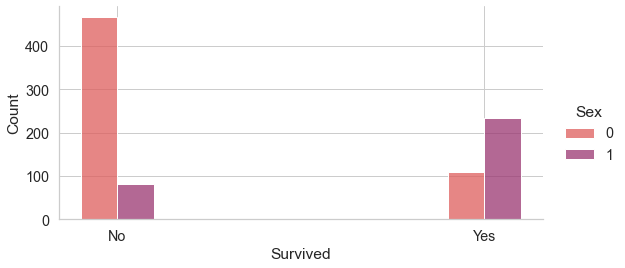

In [598]:
# --- Plot the relationship between 'Survived' and 'Sex' ---

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=df_temp, x="Survived", kind="hist", hue="Sex", multiple="dodge", palette="flare", 
            height=4.0, aspect=2.0, discrete=True, shrink=.2);
plt.xticks([0,1],['No','Yes']);

It seems most of the females survived but unfortunately most of the males died.

In [356]:
# --- Add Sex feature to our dataframes ---

df_bin['Sex'] = train['Sex']
df_con['Sex'] = train['Sex']

### 2.5. Feature: Age

In [425]:
# --- Calculate the number of missing Age values ---

train.Age.isnull().sum()

177

In [457]:
# --- Check the unique values and sort them ---

df_temp = pd.DataFrame()
df_temp = train['Age'].unique()
df_temp.sort()
print(df_temp)

[ 0.42  0.67  0.75  0.83  0.92  1.    2.    3.    4.    5.    6.    7.
  8.    9.   10.   11.   12.   13.   14.   14.5  15.   16.   17.   18.
 19.   20.   20.5  21.   22.   23.   23.5  24.   24.5  25.   26.   27.
 28.   28.5  29.   30.   30.5  31.   32.   32.5  33.   34.   34.5  35.
 36.   36.5  37.   38.   39.   40.   40.5  41.   42.   43.   44.   45.
 45.5  46.   47.   48.   49.   50.   51.   52.   53.   54.   55.   55.5
 56.   57.   58.   59.   60.   61.   62.   63.   64.   65.   66.   70.
 70.5  71.   74.   80.     nan]


There are values lower than 1 which is not possible. Let's fix this.

In [458]:
# --- Multiply the values which are lower than 1 by 100 ---

train.loc[(train['Age'] < 1), 'Age'] = train['Age'] * 100

There are also NaN values to be filled. We can use the average to fill in.

In [ ]:
# --- Calculate the mean of age feature and fill the missing values with mean ---

mean_age = int(train['Age'].mean())
train['Age'].fillna(mean_age, inplace=True)

In [505]:
# --- Add Age feature to our dataframes ---

df_bin['Age'] = train['Age']
df_con['Age'] = train['Age']

### 2.6. Feature: SibSp

In [605]:
# --- How many SipSp values do we have? ---

train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

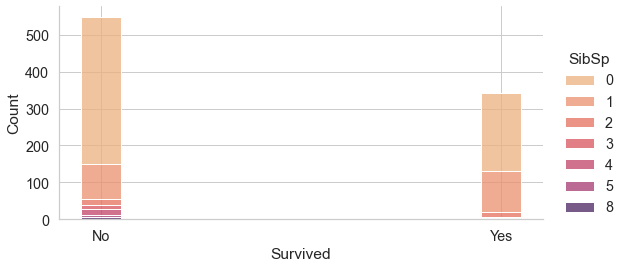

In [744]:
# --- Plot the relationship between 'Survived' and 'SibSp' ---

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=train, x="Survived", kind="hist", hue="SibSp", multiple="stack", palette="flare", 
            height=4.0, aspect=2.0, discrete=True, shrink=0.1)
plt.xticks([0,1],['No','Yes']);

It looks like the less number of siblings passengers have, the more chance they have to survive.

In [577]:
# --- Add SibSp feature to our dataframes ---

df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

### 2.7. Feature: Parch

In [604]:
# --- How many Parch values do we have? ---

train['Parch'].value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

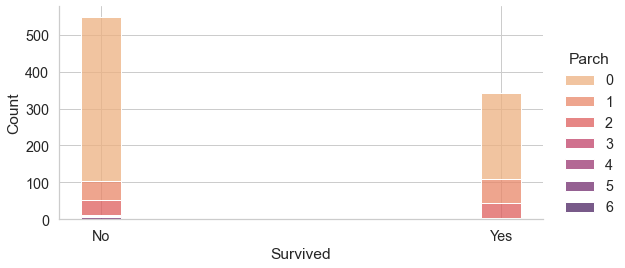

In [772]:
# --- Plot the relationship between 'Survived' and 'SibSp' ---

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=train, x="Survived", kind="hist", hue="Parch", multiple="stack", palette="flare", 
            height=4.0, aspect=2.0, discrete=True, shrink=0.1)
plt.xticks([0,1],['No','Yes']);

It looks like the less number of parents/children passengers have, the more chance they have to survive.

In [610]:
# --- Add Parch feature to our dataframes ---

df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

### 2.8. Feature: Ticket

In [681]:
# --- How many Ticket values do we have? ---

train['Ticket'].value_counts()

347082             7
1601               7
CA. 2343           7
347088             6
CA 2144            6
                  ..
A/5 3594           1
244358             1
A/5 21174          1
SOTON/OQ 392090    1
237671             1
Name: Ticket, Length: 681, dtype: int64

There are **681** unique values but ticket number does not seem useful to me. So let's discard this feature.

### 2.9. Feature: Fare

In [709]:
# --- Check the unique values and sort them ---

df_temp = pd.DataFrame()
df_temp = train['Fare'].unique()
df_temp.sort()
print(df_temp)

[  0.       4.0125   5.       6.2375   6.4375   6.45     6.4958   6.75
   6.8583   6.95     6.975    7.0458   7.05     7.0542   7.125    7.1417
   7.225    7.2292   7.25     7.3125   7.4958   7.5208   7.55     7.6292
   7.65     7.725    7.7292   7.7333   7.7375   7.7417   7.75     7.775
   7.7875   7.7958   7.8      7.8292   7.8542   7.875    7.8792   7.8875
   7.8958   7.925    8.0292   8.05     8.1125   8.1375   8.1583   8.3
   8.3625   8.4042   8.4333   8.4583   8.5167   8.6542   8.6625   8.6833
   8.7125   8.85     9.       9.2167   9.225    9.35     9.475    9.4833
   9.5      9.5875   9.825    9.8375   9.8417   9.8458  10.1708  10.4625
  10.5     10.5167  11.1333  11.2417  11.5     12.      12.275   12.2875
  12.35    12.475   12.525   12.65    12.875   13.      13.4167  13.5
  13.7917  13.8583  13.8625  14.      14.1083  14.4     14.4542  14.4583
  14.5     15.      15.0458  15.05    15.1     15.2458  15.5     15.55
  15.7417  15.75    15.85    15.9     16.      16.1     16.7  

So the range of the Fare values is 0 - 512 (but most of them are less than 100).

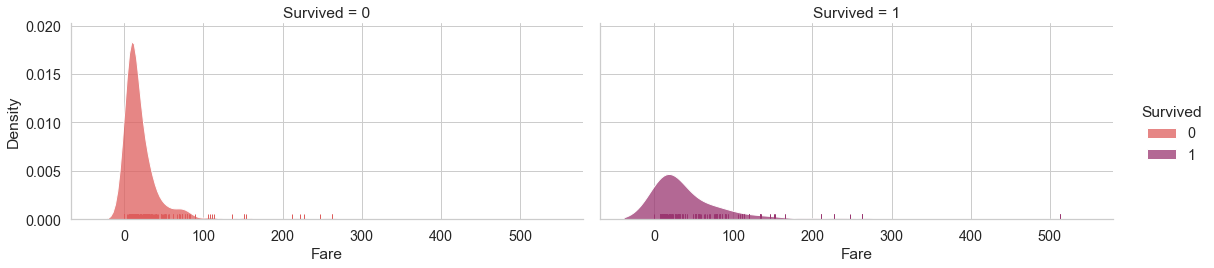

In [771]:
# --- Plot the relationship between 'Survived' and 'Fare' ---

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.displot(data=train, x="Fare", kind="kde", hue="Survived", col="Survived", multiple="stack", palette="flare", rug=True,
            height=4.0, aspect=2.0);

In [773]:
# --- Add Fare feature to our dataframes ---

df_bin['Fare'] = train['Fare']
df_con['Fare'] = train['Fare']

### 2.9. Feature: Embarked

In [791]:
# --- Calculate the number of missing Embarked values ---

train.Embarked.isnull().sum()

2

In [797]:
# --- How many Embarked values do we have? ---

train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [798]:
# --- Fill the missing values with 'S' which is the most frequent one ---

train['Embarked'].fillna("S", inplace=True)

In [800]:
# --- Add Embarked feature to our dataframes ---

df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

### 2.10. Feature: Cabin

In [784]:
# --- Calculate the number of missing Cabin values ---

train.Cabin.isnull().sum()

687

There are **687** missing values for Cabin so i2S better not to use this feature for prediction.

## 3.  Feature Encoding

Now, we have 2 different dataframes:

* df_bin &#8594; for discretised continous variable / binned
* df_con &#8594; for continous variables

In [1128]:
df_bin.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [1130]:
df_con.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Both of these dataframes are now identical but we will encode them accordingly.

### 3.1. Encoding

In [1022]:
# --- Create a new dataframe ---

df_bin_encoded = pd.DataFrame()

#### 3.1.1. Encoding: Survived

Since `Survived` feature includes only 0s and 1s, we don't need to encode it. 

In [1023]:
# --- Add Survived feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, df_bin['Survived']], axis=1)
df_bin_encoded = df_bin_encoded.astype(int)

#### 3.1.2. Encoding: Pclass

In [1025]:
# --- Encode Pclass feature ---

Pclass_encoded = pd.get_dummies(df_bin['Pclass'], prefix='Pclass')

In [1026]:
# --- Add Pclass feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Pclass_encoded], axis=1)

#### 3.1.3. Encoding: Name

We will encode `Name` feature according to abbreviations **Mr.**, **Mrs.**, **Miss.** and **Master**.

In [1029]:
# --- Now, let's create new columns for each abbreviation ---

Name_encoded = pd.DataFrame()
Name_encoded['Abbr_Mr'] = df_bin['Name'].apply(lambda x: 1 if ' Mr. ' in x else 0)
Name_encoded['Abbr_Mrs'] = df_bin['Name'].apply(lambda x: 1 if ' Mrs.' in x else 0)
Name_encoded['Abbr_Miss'] = df_bin['Name'].apply(lambda x: 1 if ' Miss.' in x else 0)
Name_encoded['Abbr_Master'] = df_bin['Name'].apply(lambda x: 1 if 'Master' in x else 0)

In [1030]:
# --- Add Name feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Name_encoded], axis=1)

#### 3.1.4. Encoding: Sex

In [1032]:
# --- Encode Sex feature ---

Sex_encoded = pd.get_dummies(df_bin['Sex'], prefix='Sex')

In [1033]:
# --- Add Sex feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Sex_encoded], axis=1)

#### 3.1.5. Encoding: Age

We will encode `Age` feature with binning.

In [1037]:
# --- Binning for Age feature ---

df_temp = pd.DataFrame()
bin_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
df_temp['Age_bin'] = pd.cut(df_bin['Age'], bins=bin_list, labels=label_list)

In [1039]:
# --- Encode Age feature ---

age_encoded = pd.get_dummies(df_temp['Age_bin'], prefix='Age')

In [1041]:
# --- Add Age feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, age_encoded], axis=1)

#### 3.1.6. Encoding: SibSp

In [1217]:
# --- Encode SibSp feature ---

SibSp_encoded = pd.get_dummies(df_bin['SibSp'], prefix='SibSp')

In [1218]:
# --- Add SibSp feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, SibSp_encoded], axis=1)

#### 3.1.7. Encoding: Parch

In [1050]:
# --- Encode Parch feature ---

Parch_encoded = pd.get_dummies(df_bin['Parch'], prefix='Parch')

In [1051]:
# --- Add SibSp feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Parch_encoded], axis=1)

#### 3.1.8. Encoding: Fare

We will encode `Fare` feature with binning.

In [1054]:
# --- Encode Fare feature ---

df_temp = pd.DataFrame()
bin_list = [0, 25, 50, 75, 100, 150, 200, 300, 400, 500, 600]
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
df_temp['Fare_bin'] = pd.cut(df_bin['Fare'], bins=bin_list, labels=label_list)

In [1060]:
# --- Encode Fare feature ---

Fare_encoded = pd.get_dummies(df_temp['Fare_bin'], prefix='Fare')

In [1061]:
# --- Add Fare feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Fare_encoded], axis=1)

#### 3.1.9. Encoding: Embarked

In [1064]:
# --- Encode Embarked feature ---

Embarked_encoded = pd.get_dummies(df_bin['Embarked'], prefix='Embarked')

In [1066]:
# --- Add Embarked feature to encoded dataframe ---

df_bin_encoded = pd.concat([df_bin_encoded, Embarked_encoded], axis=1)

## 4.  Machine Learning Models

This is our encoded dataframe. We need to split this dataframe into data and labels.

In [1221]:
df_bin_encoded.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Abbr_Mr,Abbr_Mrs,Abbr_Miss,Abbr_Master,Sex_female,Sex_male,...,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,1,0,0,1,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
3,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


In [1265]:
# --- Split the dataframe into data and labels ---

X = df_bin_encoded.drop('Survived', axis=1) # data
y = df_bin_encoded.Survived # labels

In [1266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [1267]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

## 5.  Submission

In [1144]:
# --- We need our test dataframe to look like this one ---

X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Abbr_Mr,Abbr_Mrs,Abbr_Miss,Abbr_Master,Sex_female,Sex_male,Age_A,...,Fare_D,Fare_E,Fare_F,Fare_G,Fare_H,Fare_I,Fare_J,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [1145]:
# --- Our test dataframe has some columns our model hasn't been trained on ---

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1146]:
# --- Encode Pclass feature ---

test_Pclass_encoded = pd.get_dummies(test['Pclass'], prefix='Pclass')

In [1176]:
# --- Calculate the number of rows for each abbreviation ---

no_mr = test['Name'].str.contains(' Mr. ', case=False).sum()
no_mrs = test['Name'].str.contains(' Mrs.', case=False).sum()
no_miss = test['Name'].str.contains(' Miss.', case=False).sum()
no_other = test.shape[0] - no_mr - no_mrs - no_miss

print(f"{'Number of passengers with Mr:':<35} {no_mr}")
print(f"{'Number of passengers with Mrs:':<35} {no_mrs}")
print(f"{'Number of passengers with Miss:':<35} {no_miss}")
print(f"{'-' * 40}")
print(f"{'Number of remaining passengers:':<35} {no_other}")

Number of passengers with Mr:       240
Number of passengers with Mrs:      72
Number of passengers with Miss:     78
----------------------------------------
Number of remaining passengers:     28


In [1177]:
# --- Increase the max_rows and max_colwitdh values to be able to see all rows and columns properly ---

pd.set_option("max_rows", None)
pd.set_option("max_colwidth", None)

In [1178]:
# --- List the remaining 28 passengers ---

df = test.loc[(test['Name'].str.contains(' Mr. ', case=False) == False) & 
               (test['Name'].str.contains(' Mrs. ', case=False) == False) & 
               (test['Name'].str.contains(' Miss. ', case=False) == False)]

df[['PassengerId', 'Name', 'Sex']].sort_values('Sex')

,PassengerId,Name,Sex
88,980,"O'Donoghue, Ms. Bridget",female
414,1306,"Oliva y Ocana, Dona. Fermina",female
21,913,"Olsen, Master. Artur Karl",male
392,1284,"Abbott, Master. Eugene Joseph",male
389,1281,"Palsson, Master. Paul Folke",male
379,1271,"Asplund, Master. Carl Edgar",male
360,1252,"Sage, Master. William Henry",male
344,1236,"van Billiard, Master. James William",male
339,1231,"Betros, Master. Seman",male
307,1199,"Aks, Master. Philip Frank",male


In [1179]:
# --- Fix the female names ---

test.loc[88, 'Name'] = 'Donoghue, Miss. Bridget' # Ms = Miss
test.loc[414, 'Name'] = 'Oliva y Ocana, Dona. Miss. Fermina' # added Miss

In [1181]:
# --- Fix the male names who are not 'Master' ---

test.loc[(test['Sex'] == 'male') & 
          (~test['Name'].str.contains(' Mr. ', case=False)) &
          (~test['Name'].str.contains('Master', case=False)), 'Name'] = test['Name'].astype(str) + ' Mr. '

In [1182]:
# --- Now all the names have one abbreviation ---

no_mr = test['Name'].str.contains(' Mr. ', case=False).sum()
no_mrs = test['Name'].str.contains(' Mrs.', case=False).sum()
no_miss = test['Name'].str.contains(' Miss.', case=False).sum()
no_master = test['Name'].str.contains('Master', case=False).sum()
no_other = test.shape[0] - no_mr - no_mrs - no_miss - no_master

print(f"{'Number of passengers with Mr:':<35} {no_mr}")
print(f"{'Number of passengers with Mrs:':<35} {no_mrs}")
print(f"{'Number of passengers with Miss:':<35} {no_miss}")
print(f"{'Number of passengers with Master:':<35} {no_master}")
print(f"{'-' * 40}")
print(f"{'Number of remaining passengers:':<35} {no_other}")


Number of passengers with Mr:       245
Number of passengers with Mrs:      72
Number of passengers with Miss:     80
Number of passengers with Master:   21
----------------------------------------
Number of remaining passengers:     0


In [1183]:
# --- Set the max_rows and max_colwitdh values to default again ---

pd.set_option("max_rows", 60)
pd.set_option("max_colwidth", 50)

In [1186]:
# --- Now, let's create new columns for each abbreviation ---

test_Name_encoded = pd.DataFrame()
test_Name_encoded['Abbr_Mr'] = test['Name'].apply(lambda x: 1 if ' Mr. ' in x else 0)
test_Name_encoded['Abbr_Mrs'] = test['Name'].apply(lambda x: 1 if ' Mrs.' in x else 0)
test_Name_encoded['Abbr_Miss'] = test['Name'].apply(lambda x: 1 if ' Miss.' in x else 0)
test_Name_encoded['Abbr_Master'] = test['Name'].apply(lambda x: 1 if 'Master' in x else 0)

In [1188]:
# --- Encode Sex feature ---

test_Sex_encoded = pd.get_dummies(test['Sex'], prefix='Sex')

In [1190]:
# --- Binning for Age feature ---

test_df_temp = pd.DataFrame()
bin_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
test_df_temp['Age_bin'] = pd.cut(test['Age'], bins=bin_list, labels=label_list)

In [1191]:
# --- Encode Age feature ---

test_age_encoded = pd.get_dummies(test_df_temp['Age_bin'], prefix='Age')

In [1193]:
# --- Encode SibSp feature ---

test_SibSp_encoded = pd.get_dummies(test['SibSp'], prefix='SibSp')

In [1197]:
# --- Encode Parch feature ---

test_Parch_encoded = pd.get_dummies(test['Parch'], prefix='Parch')

In [1198]:
# --- Encode Fare feature ---

test_df_temp = pd.DataFrame()
bin_list = [0, 25, 50, 75, 100, 150, 200, 300, 400, 500, 600]
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
test_df_temp['Fare_bin'] = pd.cut(test['Fare'], bins=bin_list, labels=label_list)

In [1199]:
# --- Encode Fare feature ---

test_Fare_encoded = pd.get_dummies(test_df_temp['Fare_bin'], prefix='Fare')

In [1200]:
# --- Encode Embarked feature ---

test_Embarked_encoded = pd.get_dummies(test['Embarked'], prefix='Embarked')

In [1225]:
# --- Combine the test encoded columns with test ---

test = pd.concat([test, 
                  test_Pclass_encoded, 
                  test_Name_encoded,
                  test_Sex_encoded, 
                  test_age_encoded,
                  test_SibSp_encoded,
                  test_Parch_encoded,
                  test_Fare_encoded,
                  test_Embarked_encoded], axis=1)

In [1226]:
# ---  Let's look at test, it should have one hot encoded columns now ---

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_D,Fare_E,Fare_F,Fare_G,Fare_H,Fare_I,Fare_J,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,0,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,0,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,0,0,0,0,1


In [1227]:
# --- Create a list of columns to be used for the predictions ---

wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Abbr_Mr', 'Abbr_Mrs', 'Abbr_Miss',
       'Abbr_Master', 'Sex_female', 'Sex_male', 'Age_A', 'Age_B', 'Age_C',
       'Age_D', 'Age_E', 'Age_F', 'Age_G', 'Age_H', 'Age_I', 'Age_J',
       'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5',
       'Parch_6', 'Fare_A', 'Fare_B', 'Fare_C', 'Fare_D', 'Fare_E', 'Fare_F',
       'Fare_G', 'Fare_H', 'Fare_I', 'Fare_J', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8'],
      dtype='object')

In [1254]:
# --- Make the prediction with fitted model ---

prediction = model.predict(test[wanted_test_columns])

In [1255]:
# --- Create the submission dataframe ---

submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = prediction # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [1257]:
# --- Create the submission file ---

submission.to_csv('titanic_submission_decision_tree.csv', index=False)